# Differential gene expression analysis

This notebook will focus on the third objective, i.e. evaluate the whether or not the same trend will show for fatty liver patient only.

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [2]:
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Import data

In [3]:
file_path = "../datasets/E-MTAB-6863-raw-counts.tsv"
df = pd.read_csv(file_path, sep="\t", comment='#')
df.head()

Gene ID Gene Name  ERR2618748  ERR2618749  ERR2618751  ERR2618752  \
0  ENSG00000000003    TSPAN6        2230        1191        1592        1936   
1  ENSG00000000005      TNMD          12           6           5           2   
2  ENSG00000000419      DPM1         404         339         396         326   
3  ENSG00000000457     SCYL3         670         422         375         347   
4  ENSG00000000460  C1orf112         111         116          97          73   

   ERR2618753  ERR2618754  ERR2618755  ERR2618756  ERR2618757  ERR2618758  \
0        1506        1717        1489        1882        1109         364   
1           3           1           1          21          19           5   
2         343         335         292         491         275         381   
3         417         403         318         528         338         230   
4          64         108          38         153          86          77   

   ERR2618759  ERR2618760  ERR2618761  ERR2618762  ERR2618763  ERR2618764  \
0        1740        1311         921        1376        1133        1822   
1          13           2           0           1           6           4   
2         332         284         273         391         184         326   
3         347         285         434         372         214         407   
4          85          53          82          75          33         123   

   ERR2618765  ERR2618766  ERR2618781  ERR2618782  ERR2618784  ERR2618785  \
0        1490        1334        1241        1221        1901         797   
1           1          10           1           3           2          16   
2         345         257         419         263         430         233   
3         366         268         516         386         604         400   
4          56          49          92          94         242         115   

   ERR2618786  ERR2618787  ERR2618788  ERR2618789  ERR2618790  ERR2618791  \
0         858        1064         390        1517        1067         421   
1           4           0           2           0           1           1   
2         193         187          74         291         267          56   
3         303         222         127         180         336          37   
4          84          61          22          50         122          19   

   ERR2618802  ERR2618803  ERR2618804  ERR2618805  ERR2618806  ERR2618807  \
0         489         354        1584        1296        2202        1444   
1           1           3           8           2           8           3   
2         101          87         380         262         486         393   
3         178         175         598         379         623         272   
4          56          88         239         122         366         134   

   ERR2618808  ERR2618809  ERR2618810  ERR2618811  ERR2618814  ERR2618769  \
0        2015        1262        1262        1915         705        1084   
1          12           5           4           3           2           4   
2         431         287         192         325         102         124   
3         677         324         220         351         102         214   
4         199          99          37         139          29          76   

   ERR2618773  ERR2618783  ERR2618770  ERR2618774  ERR2618795  ERR2618813  \
0        1329         551        1795        1560         365        1123   
1           0           0           5           6           5           5   
2         263          96         372         272          77         290   
3         427         124         440         499          74         388   
4          73          47         159         100          30         109   

   ERR2618776  ERR2618779  ERR2618812  ERR2618777  ERR2618796  ERR2618797  \
0         537        1928        2536        1654         529         844   
1           5          11          35           8           2           1   
2         141         323         439         392         

In [4]:
# Examine all patients
file_path = "../datasets/E-MTAB-6863-experiment-design.tsv"
edf = pd.read_csv(file_path, sep="\t", comment='#')
edf = edf[edf["Sample Characteristic[disease]"] == "non-alcoholic fatty liver disease"]
print(edf.shape)
edf.head()

(12, 46)


Run Sample Characteristic[age]  \
55  ERR2618803                    53 year   
56  ERR2618804                    51 year   
57  ERR2618805                    29 year   
58  ERR2618806                    37 year   
59  ERR2618807                    58 year   

    Sample Characteristic Ontology Term[age]  \
55                                       NaN   
56                                       NaN   
57                                       NaN   
58                                       NaN   
59                                       NaN   

   Sample Characteristic[alcohol consumption]  \
55                           0 grams per week   
56                           0 grams per week   
57                           0 grams per week   
58                           0 grams per week   
59                           0 grams per week   

    Sample Characteristic Ontology Term[alcohol consumption]  \
55                                                       NaN   
56                                                       NaN   
57                                                       NaN   
58                                                       NaN   
59                                                       NaN   

   Sample Characteristic[alcohol consumption measurement]  \
55                                                      0   
56                                                      0   
57                                                      0   
58                                                      0   
59                                                      0   

    Sample Characteristic Ontology Term[alcohol consumption measurement]  \
55                                                                   NaN   
56                                                                   NaN   
57                                                                   NaN   
58                                                                   NaN   
59                                                                   NaN   

    Sample Characteristic[bmi code]  \
55                                1   
56                                1   
57                                1   
58                                1   
59                                1   

    Sample Characteristic Ontology Term[bmi code]  \
55                                            NaN   
56                                            NaN   
57                                            NaN   
58                                            NaN   
59                                            NaN   

   Sample Characteristic[body mass index]  \
55                                   37.7   
56                                     32   
57                                   30.7   
58                                   32.7   
59                                   39.6   

    Sample Characteristic Ontology Term[body mass index]  \
55                                                   NaN   
56                                                   NaN   
57                                                   NaN   
58                                                   NaN   
59                                                   NaN   

   Sample Characteristic[cigarette packs per year]  \
55                      0 cigarette packs per year   
56                     13 cigarette packs per year   
57                     15 cigarette packs per year   
58                     17 cigarette packs per year   
59                     25 cigarette packs per year   

    Sample Characteristic Ontology Term[cigarette packs per year]  \
55                                                            NaN   
56                                                            NaN   
57                                                            NaN   
58                                                            NaN   
59                                                            NaN   

   Sample Characteris

In [5]:
# Filter counts df by only non-alcoholic fatty liver disease patients
counts_df = df[["Gene ID"] + edf["Run"].tolist()].set_index("Gene ID")
print(counts_df.shape)
counts_df.head()

(58735, 12)


ERR2618803  ERR2618804  ERR2618805  ERR2618806  ERR2618807  \
Gene ID                                                                       
ENSG00000000003         354        1584        1296        2202        1444   
ENSG00000000005           3           8           2           8           3   
ENSG00000000419          87         380         262         486         393   
ENSG00000000457         175         598         379         623         272   
ENSG00000000460          88         239         122         366         134   

                 ERR2618808  ERR2618809  ERR2618810  ERR2618811  ERR2618812  \
Gene ID                                                                       
ENSG00000000003        2015        1262        1262        1915        2536   
ENSG00000000005          12           5           4           3          35   
ENSG00000000419         431         287         192         325         439   
ENSG00000000457         677         324         220         351         478   
ENSG00000000460         199          99          37         139         135   

                 ERR2618813  ERR2618814  
Gene ID                                  
ENSG00000000003        1123         705  
ENSG00000000005           5           2  
ENSG00000000419         290         102  
ENSG00000000457         388         102  
ENSG00000000460         109          29

## EDA

In [6]:
# Check the distributions of read counts for each sample
summary_df = counts_df.describe().round()
summary_df.loc["sum"] = summary_df.loc["count"] * summary_df.loc["mean"]
summary_df

ERR2618803  ERR2618804  ERR2618805  ERR2618806  ERR2618807  ERR2618808  \
count     58735.0     58735.0     58735.0     58735.0     58735.0     58735.0   
mean        105.0       351.0       270.0       430.0       232.0       421.0   
std        2184.0      9957.0      7180.0     13568.0      7878.0     11857.0   
min           0.0         0.0         0.0         0.0         0.0         0.0   
25%           0.0         0.0         0.0         0.0         0.0         0.0   
50%           1.0         2.0         2.0         2.0         1.0         3.0   
75%          17.0        41.0        35.0        44.0        22.0        55.0   
max      407997.0   2208501.0   1601834.0   3065929.0   1717770.0   2633354.0   
sum     6167175.0  20615985.0  15858450.0  25256050.0  13626520.0  24727435.0   

       ERR2618809  ERR2618810  ERR2618811  ERR2618812  ERR2618813  ERR2618814  
count     58735.0     58735.0     58735.0     58735.0     58735.0     58735.0  
mean        230.0       240.0       261.0       377.0       213.0       139.0  
std        6322.0      6950.0     10165.0     12306.0      5990.0      3313.0  
min           0.0         0.0         0.0         0.0         0.0         0.0  
25%           0.0         0.0         0.0         0.0         0.0         0.0  
50%           1.0         0.0         1.0         2.0         2.0         0.0  
75%          26.0        14.0        20.0        35.0        31.0         8.0  
max     1403098.0   1456999.0   2328158.0   2786235.0   1324729.0    564478.0  
sum    13509050.0  14096400.0  15329835.0  22143095.0  12510555.0   8164165.0

In [7]:
# Check read count per sample by millions
summary_df.loc["sum"] / 1e6

ERR2618803     6.167175
ERR2618804    20.615985
ERR2618805    15.858450
ERR2618806    25.256050
ERR2618807    13.626520
ERR2618808    24.727435
ERR2618809    13.509050
ERR2618810    14.096400
ERR2618811    15.329835
ERR2618812    22.143095
ERR2618813    12.510555
ERR2618814     8.164165
Name: sum, dtype: float64

In [8]:
# Filter the data with a threshold of ≥10 counts per million (CPM) in at least 3 samples (~29%)
# This is based on the paper
threshold = summary_df.loc["sum"]/1e6 * 10
counts_df1 = counts_df
filtered_df = counts_df[(counts_df1 > threshold).sum(axis=1) >= 3]
print(filtered_df.shape)
filtered_df.head()

(9971, 12)


ERR2618803  ERR2618804  ERR2618805  ERR2618806  ERR2618807  \
Gene ID                                                                       
ENSG00000000003         354        1584        1296        2202        1444   
ENSG00000000419          87         380         262         486         393   
ENSG00000000457         175         598         379         623         272   
ENSG00000000460          88         239         122         366         134   
ENSG00000000971       13910       59106       36663       90130       46373   

                 ERR2618808  ERR2618809  ERR2618810  ERR2618811  ERR2618812  \
Gene ID                                                                       
ENSG00000000003        2015        1262        1262        1915        2536   
ENSG00000000419         431         287         192         325         439   
ENSG00000000457         677         324         220         351         478   
ENSG00000000460         199          99          37         139         135   
ENSG00000000971       69927       35273       29166       61554       64106   

                 ERR2618813  ERR2618814  
Gene ID                                  
ENSG00000000003        1123         705  
ENSG00000000419         290         102  
ENSG00000000457         388         102  
ENSG00000000460         109          29  
ENSG00000000971       26802        7260

This yields a similar number compared to all samples.

### PCA analysis

In [9]:
pca = PCA(n_components=3)
normalized_df=pd.DataFrame(StandardScaler().fit_transform(filtered_df.T))

pca.fit(normalized_df)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.75550227 0.08283526 0.0468521 ]
[300.66153332  99.55603434  74.87287901]


In [10]:
projected = pca.fit_transform(normalized_df)
print(normalized_df.shape)
print(projected.shape)

(12, 9971)
(12, 3)


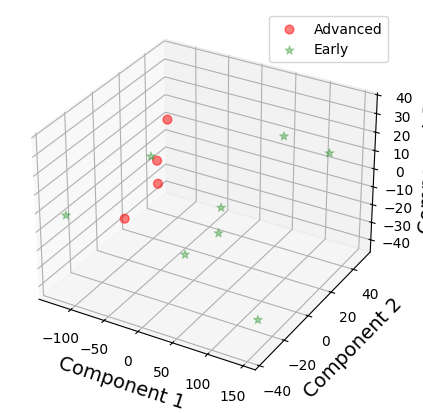

In [11]:
y=edf["Sample Characteristic[disease staging]"]

ex_variance=np.var(projected,axis=0)
ex_variance_ratio = ex_variance/np.sum(ex_variance)
ex_variance_ratio


Xax = projected[:,0]
Yax = projected[:,1]
Zax = projected[:,2]

cdict = {'early':'green','advanced':'red'}
label = {'early':'Early','advanced':'Advanced'}
marker = {'early':'*','advanced':'o'}
alpha = {'early':.3, 'advanced':.5}

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(projection='3d')

fig.patch.set_facecolor('white')
for l in np.unique(y):
 ix=np.where(y==l)
 ax.scatter(Xax[ix], Yax[ix], Zax[ix], c=cdict[l], s=40,
           label=label[l], marker=marker[l], alpha=alpha[l])
# for loop ends
ax.set_xlabel("Component 1", fontsize=14)
ax.set_ylabel("Component 2", fontsize=14)
ax.set_zlabel("Component 3", fontsize=14)

ax.legend()
plt.show()

This time the early and advanced seems pretty differnt by first component already, except for two. Maybe they are real or may be they are borderline advanced. 

## Differential expression analysis

In [12]:
# Transform the data to be sample as rows and genes as columns
filtered_df = filtered_df.T
print(filtered_df.shape)
filtered_df.head()

(12, 9971)


Gene ID     ENSG00000000003  ENSG00000000419  ENSG00000000457  \
ERR2618803              354               87              175   
ERR2618804             1584              380              598   
ERR2618805             1296              262              379   
ERR2618806             2202              486              623   
ERR2618807             1444              393              272   

Gene ID     ENSG00000000460  ENSG00000000971  ENSG00000001036  \
ERR2618803               88            13910              150   
ERR2618804              239            59106              495   
ERR2618805              122            36663              406   
ERR2618806              366            90130              798   
ERR2618807              134            46373              349   

Gene ID     ENSG00000001084  ENSG00000001167  ENSG00000001461  \
ERR2618803             1038              169              126   
ERR2618804             3467              448              284   
ERR2618805             2810              399              254   
ERR2618806             4496              496              426   
ERR2618807             2224              261              185   

Gene ID     ENSG00000001497  ENSG00000001561  ENSG00000001617  \
ERR2618803              129               72               74   
ERR2618804              383              419              209   
ERR2618805              329              195              214   
ERR2618806              486              298              202   
ERR2618807              217              265              140   

Gene ID     ENSG00000001626  ENSG00000001629  ENSG00000001630  \
ERR2618803               85              307              220   
ERR2618804               84             1100              293   
ERR2618805              115              827              312   
ERR2618806              377             1093              374   
ERR2618807              187              595              434   

Gene ID     ENSG00000001631  ENSG00000002016  ENSG00000002330  \
ERR2618803               84              126               56   
ERR2618804              255              332              197   
ERR2618805              240              279              144   
ERR2618806              257              369              268   
ERR2618807              106              135              131   

Gene ID     ENSG00000002549  ENSG00000002586  ENSG00000002726  \
ERR2618803              555              485              201   
ERR2618804             2147             1199              236   
ERR2618805             1635             1139              208   
ERR2618806             3141             1995              457   
ERR2618807             1967              973              104   

Gene ID     ENSG00000002822  ENSG00000002834  ENSG00000002919  \
ERR2618803              131              591               48   
ERR2618804              340             1866              248   
ERR2618805              288             1499              176   
ERR2618806              410             2212              272   
ERR2618807              204              939              123   

Gene ID     ENSG00000002933  ENSG00000003056  ENSG00000003147  \
ERR2618803             1830              145               53   
ERR2618804             5301              625              101   
ERR2618805             3525              497              302   
ERR2618806             8895              783              724   
ERR2618807             4888              462               67   

Gene ID     ENSG00000003393  ENSG00000003400  ENSG00000003402  \
ERR2618803              566              181             1573   
ERR2618804             1556              434             4317   
ERR2618805             1311              363             3059   
ERR2618806             2113              561             4161   
ERR2618807              996              251             1731   

Gene ID     ENSG00000003436  ENSG00000003509  ENSG00000003756  \
ERR2618803             19

In [13]:
# Prep the metadata to have the groups to run differential expression on
metadata = edf[["Run","Sample Characteristic[disease]", "Sample Characteristic[disease staging]"]]
metadata = metadata.rename(columns={"Sample Characteristic[disease]": "condition", 
                         "Sample Characteristic[disease staging]": "stage"})
metadata = metadata.set_index("Run")
print(metadata.shape)
metadata.head()

(12, 2)


condition     stage
Run                                                    
ERR2618803  non-alcoholic fatty liver disease     early
ERR2618804  non-alcoholic fatty liver disease     early
ERR2618805  non-alcoholic fatty liver disease     early
ERR2618806  non-alcoholic fatty liver disease     early
ERR2618807  non-alcoholic fatty liver disease  advanced

In [14]:
dds = DeseqDataSet(
    counts=filtered_df,
    metadata=metadata,
    design_factors="stage",
)

In [15]:
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 8.35 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

Fitting MAP dispersions...
... done in 11.23 seconds.

Fitting LFCs...
... done in 5.24 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 12 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.04 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [16]:
print(dds)

AnnData object with n_obs × n_vars = 12 × 9971
    obs: 'condition', 'stage'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'


In [17]:
dds

AnnData object with n_obs × n_vars = 12 × 9971
    obs: 'condition', 'stage'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'

In [18]:
stat_res = DeseqStats(dds, independent_filter=False)

In [21]:
# stat_res.summary()
stat_res.results_df[:10]

baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Gene ID                                                                       
ENSG00000000003   1351.747436       -0.303305  0.238532 -1.271546  0.203534   
ENSG00000000419    276.500038       -0.531336  0.178414 -2.978115  0.002900   
ENSG00000000457    337.050698       -0.115765  0.173336 -0.667868  0.504218   
ENSG00000000460    123.345342       -0.105813  0.364536 -0.290267  0.771612   
ENSG00000000971  38934.918266       -0.377036  0.292721 -1.288041  0.197732   
ENSG00000001036    459.864778       -0.073952  0.241274 -0.306506  0.759219   
ENSG00000001084   2433.601154       -0.080373  0.141518 -0.567936  0.570078   
ENSG00000001167    305.390225       -0.078700  0.151286 -0.520204  0.602922   
ENSG00000001461    232.157663       -0.048179  0.142312 -0.338549  0.734950   
ENSG00000001497    270.719303        0.297724  0.144110  2.065955  0.038833   

                     padj  
Gene ID                    
ENSG00000000003  0.632267  
ENSG00000000419  0.164145  
ENSG00000000457  0.781715  
ENSG00000000460  0.913047  
ENSG00000000971  0.627398  
ENSG00000001036  0.905807  
ENSG00000001084  0.814830  
ENSG00000001167  0.828872  
ENSG00000001461  0.897821  
ENSG00000001497  0.462694

In [22]:
results_df = stat_res.results_df.sort_values(by=["padj"])
results_df.head()

baseMean  log2FoldChange     lfcSE      stat  \
Gene ID                                                            
ENSG00000138448  1104.654804       -0.830558  0.130601 -6.359518   
ENSG00000169031   115.667104       -2.020585  0.320005 -6.314236   
ENSG00000105971   526.274681       -0.744240  0.123056 -6.047981   
ENSG00000158258   136.716492       -2.329083  0.420315 -5.541274   
ENSG00000139329   570.608972       -1.886024  0.339985 -5.547366   

                       pvalue      padj  
Gene ID                                  
ENSG00000138448  2.023872e-10  0.000001  
ENSG00000169031  2.714989e-10  0.000001  
ENSG00000105971  1.466726e-09  0.000005  
ENSG00000158258  3.002781e-08  0.000060  
ENSG00000139329  2.900060e-08  0.000060

### Volcano plot

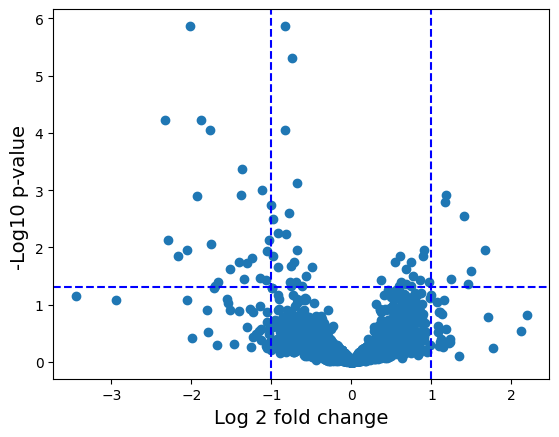

In [23]:
plt.scatter(results_df.log2FoldChange, -np.log10(results_df.padj))
plt.xlabel("Log 2 fold change", fontsize=14)
plt.ylabel("-Log10 p-value ", fontsize=14)

plt.axvline(x=1, color='b', linestyle='--')
plt.axvline(x=-1, color='b', linestyle='--')
plt.axhline(y=-np.log10(0.05), color='b', linestyle='--')

plt.show()

In [24]:
sum(results_df.padj < 0.05)

64

64 genes are differently expressed. Easier to manage...

### Heatmap

In [28]:
# Plot heatmap with only significant genes
sig_genes = results_df[results_df.padj < 0.05].index.tolist()

# keep only significant genes and transpose so genes are rows
heatmap_df = filtered_df[sig_genes].T

# merge dataframes to get gene names
heatmap_df = heatmap_df.reset_index().merge(df[["Gene ID", "Gene Name"]], on="Gene ID", how = "left") 

# remove gene with no names
heatmap_df = heatmap_df[~heatmap_df["Gene Name"].isna()] 

# remove gene id and set gene name as index
heatmap_df = heatmap_df[heatmap_df.columns[1:]].set_index("Gene Name") 

# Sort by stages: advanced vs early
heatmap_df = heatmap_df[metadata.sort_values("stage", ascending=False).index.tolist()] 

# Normalized by sample mean 
heatmap_df = (heatmap_df / heatmap_df.describe().loc["mean"] * 10).round(1)

print(heatmap_df.shape)
heatmap_df.head()

ERR2618803  ERR2618804  ERR2618805  ERR2618806  ERR2618808  \
Gene Name                                                               
ITGAV             9.9        11.7        10.1         9.6        10.6   
COL4A3            1.1         0.5         0.5         0.7         0.8   
CAV2              5.3         5.3         4.3         4.8         4.5   
CLSTN2            0.8         0.4         0.3         1.2         0.7   
LUM               2.5         2.3         2.6         6.8         4.5   

           ERR2618810  ERR2618812  ERR2618814  ERR2618807  ERR2618809  \
Gene Name                                                               
ITGAV            10.7        14.3         6.2        18.2        19.6   
COL4A3            1.0         0.7         0.2         2.2         2.7   
CAV2              5.6         6.6         3.9         9.5         8.1   
CLSTN2            0.9         0.6         0.6         3.3         4.4   
LUM               4.4         3.3         1.5        12.3        15.9   

           ERR2618811  ERR2618813  
Gene Name                          
ITGAV            18.7        19.7  
COL4A3            2.3         4.1  
CAV2             10.0         7.6  
CLSTN2            1.3         5.2  
LUM              10.9        15.2

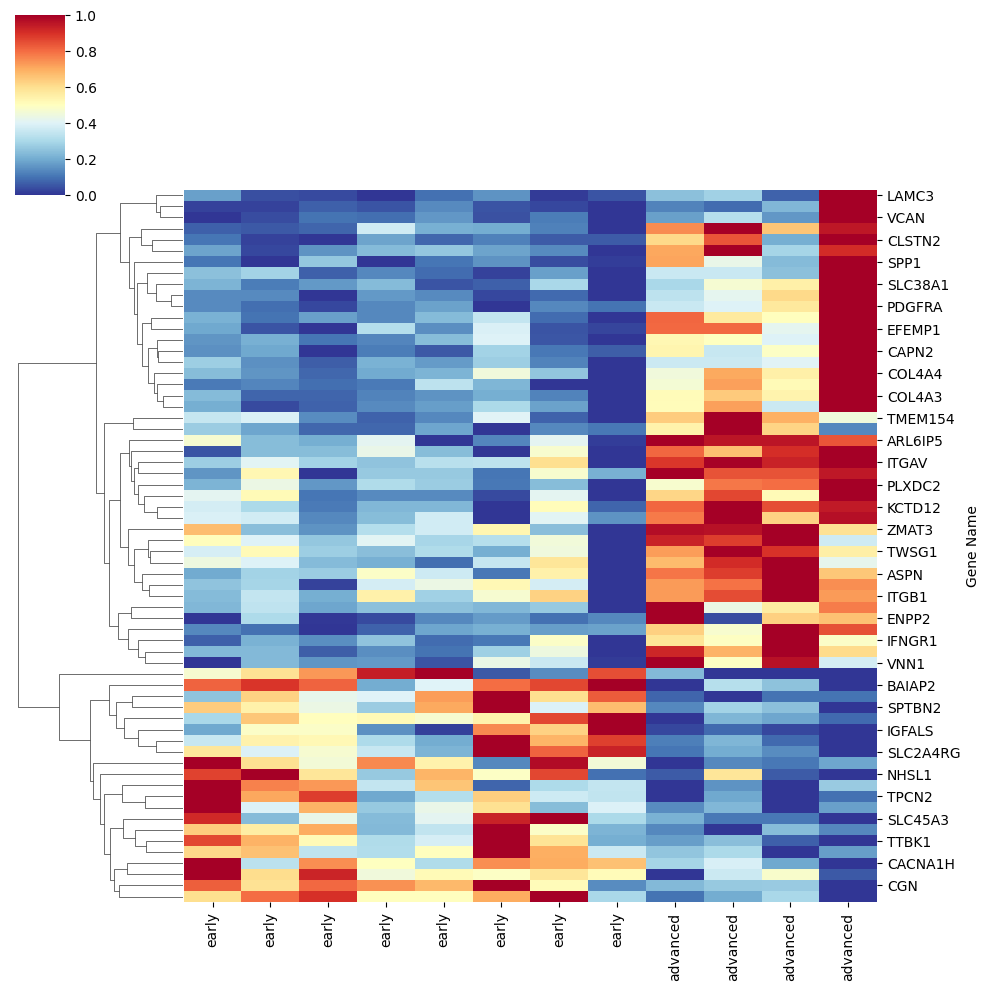

In [29]:
# Default plot
sns.clustermap(heatmap_df, standard_scale=0, cmap = 'RdYlBu_r', col_cluster=False, 
               xticklabels=metadata.sort_values("stage", ascending=False)["stage"].tolist())

# Show the graph
plt.show()

This shows a much clearer pattern for early vs. advanced. That's good.

## Preparing gene list for enrichment analysis

In [37]:
# For enrichment analysis, keep the less stringent DEGs
sig_genes1 = results_df[results_df.padj < 0.05].index.tolist()

# keep only significant genes and transpose so genes are rows
gene_df = filtered_df[sig_genes1]

gene_list = df['Gene Name'][(df['Gene ID'].isin(gene_df.columns.tolist())) & (~df['Gene Name'].isna())].tolist()

In [31]:
# with open('../outputs/gene_list_fatty_liver.pkl', 'wb') as f:
#     pkl.dump(gene_list, f)

# Functional enrichment analysis

Check enriched functions all in one notebook

In [49]:
import pickle
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import gseapy as gp
from gseapy import dotplot, barplot
from gseapy import enrichment_map

In [41]:
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [42]:
# Rezdiffra, the new FDA approved MASH treatment drug target is THRB, Thyroid Hormone Receptor-Beta
# "THRB" is not in the gene_list, so check what others Thyroid Hormone are there.

[i for i in gene_list if "TH" in i]

['TH']

TH is Tyrosine Hydroxylase. So still no Thyroid Hormone Receptorrelated stuff...

## Check functional enrichment in pathways using Enrichr API

In [43]:
# Check all available datasets to use
names = gp.get_library_name()
print(names)

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency_CellLines_2023', 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019', 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019', 'Descartes_Cell_Types_and

### KEGG 2021

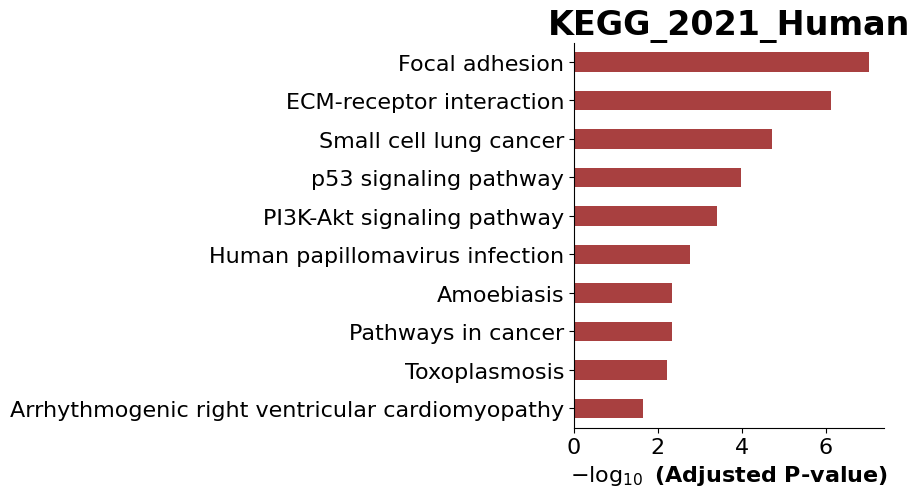

In [65]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
gene_sets = ["KEGG_2021_Human"]

enr = gp.enrichr(gene_list=gene_list, 
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

# obj.results stores all results
# enr.results.head()

# ax = dotplot(enr.res2d,cmap='viridis_r', size=6, figsize=(4,8), top_term=20)

# Use barplot because this is a much smaller size and the dot size will be too small
ax = barplot(enr.res2d, title=gene_sets[0], figsize=(4, 5), color='darkred')

### GO_Biological_Process_2023

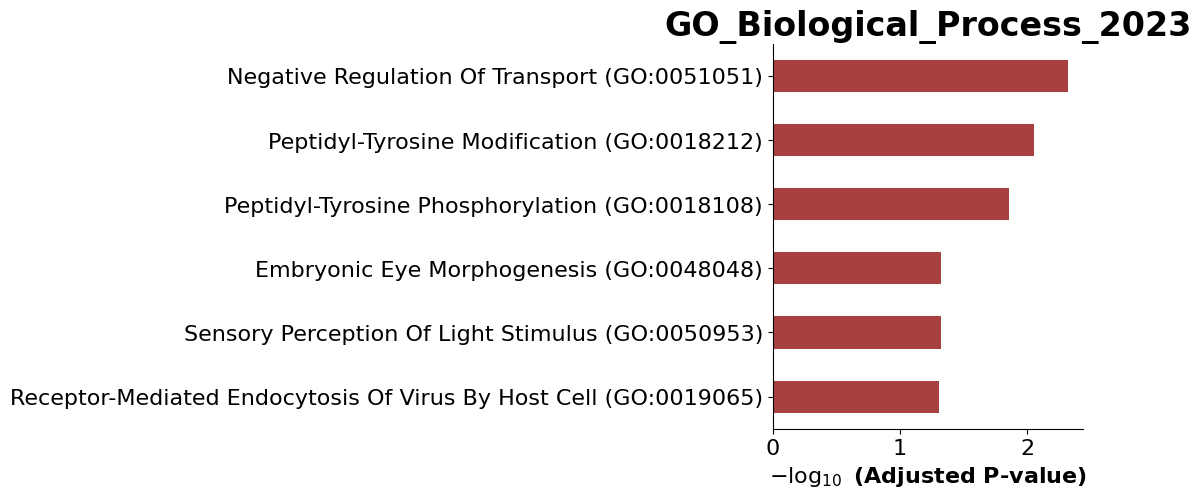

In [53]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
gene_sets = ["GO_Biological_Process_2023"]

enr = gp.enrichr(gene_list=gene_list, 
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

# obj.results stores all results
# enr.results.head()

# ax = dotplot(enr.res2d,cmap='viridis_r', size=6, figsize=(4,8), top_term=20)
ax = barplot(enr.res2d, title=gene_sets[0], figsize=(4, 5), color='darkred')

### GO_Molecular_Function_2023

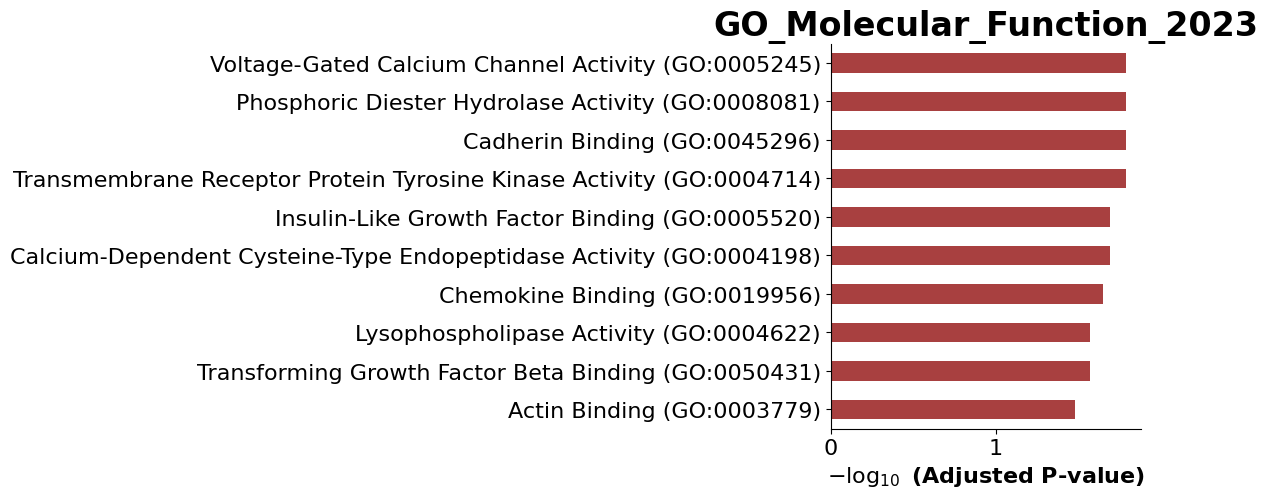

In [54]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
gene_sets = ["GO_Molecular_Function_2023"]

enr = gp.enrichr(gene_list=gene_list, 
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

# obj.results stores all results
# enr.results.head()

# ax = dotplot(enr.res2d,cmap='viridis_r', size=6, figsize=(4,8), top_term=20)
ax = barplot(enr.res2d, title=gene_sets[0], figsize=(4, 5), color='darkred')

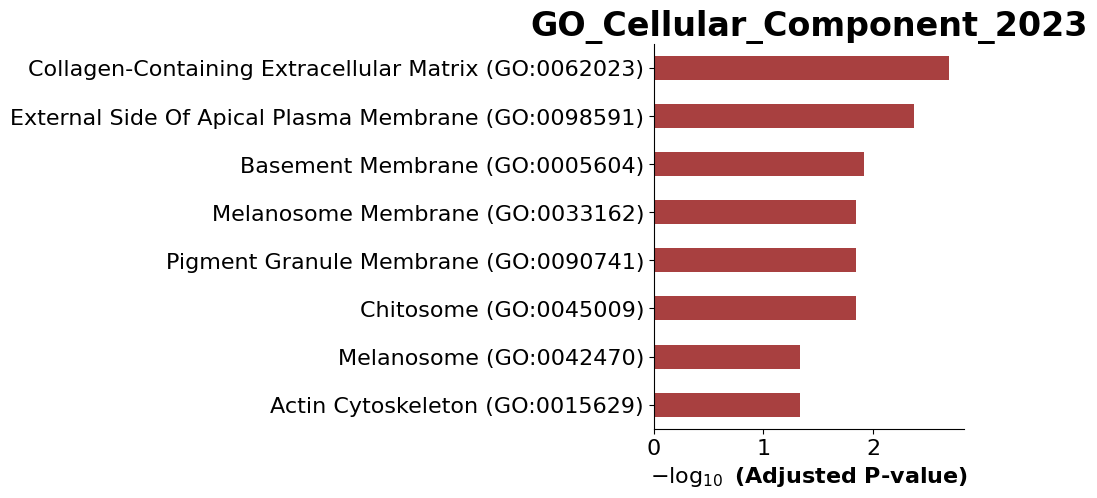

In [69]:
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
gene_sets = ["GO_Cellular_Component_2023"]

enr = gp.enrichr(gene_list=gene_list, 
                 gene_sets=gene_sets,
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

# obj.results stores all results
# enr.results.head()

# ax = dotplot(enr.res2d,cmap='viridis_r', size=6, figsize=(4,8), top_term=20)
ax = barplot(enr.res2d, title=gene_sets[0], figsize=(4, 5), color='darkred')

## Network graph

In [70]:
# return two dataframe
nodes, edges = enrichment_map(enr.res2d)

# build graph
G = nx.from_pandas_edgelist(edges,
                            source='src_idx',
                            target='targ_idx',
                            edge_attr=['jaccard_coef', 'overlap_coef', 'overlap_genes'])

In [72]:
nodes

Gene_set  \
node_idx                               
0         GO_Cellular_Component_2023   
1         GO_Cellular_Component_2023   
2         GO_Cellular_Component_2023   
3         GO_Cellular_Component_2023   
4         GO_Cellular_Component_2023   
5         GO_Cellular_Component_2023   
6         GO_Cellular_Component_2023   
7         GO_Cellular_Component_2023   

                                                           Term Overlap  \
node_idx                                                                  
0                               Actin Cytoskeleton (GO:0015629)   5/327   
1                                       Melanosome (GO:0042470)    2/31   
2                                        Chitosome (GO:0045009)    2/15   
3                         Pigment Granule Membrane (GO:0090741)    2/15   
4                              Melanosome Membrane (GO:0033162)    2/15   
5                                Basement Membrane (GO:0005604)    3/46   
6          External Side Of Apical Plasma Membrane (GO:0098591)     2/5   
7         Collagen-Containing Extracellular Matrix (GO:0062023)   8/373   

           P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
node_idx                                                                  
0         0.003928          0.046360            0                     0   
1         0.004415          0.046360            0                     0   
2         0.001030          0.014425            0                     0   
3         0.001030          0.014425            0                     0   
4         0.001030          0.014425            0                     0   
5         0.000430          0.012040            0                     0   
6         0.000100          0.004207            0                     0   
7         0.000024          0.002030            0                     0   

          Odds Ratio  Combined Score  \
node_idx                               
0           5.162122       28.595940   
1          22.143493      120.077492   
2          49.436725      340.017456   
3          49.436725      340.017456   
4          49.436725      340.017456   
5          22.752192      176.368386   
6         214.333333     1973.703188   
7           7.659883       81.429097   

                                                 Genes     p_inv  Hits_ratio  
node_idx                                                                      
0                     MARCKS;CAPN2;BAIAP2;EPHA3;SPTBN2  1.333859    0.015291  
1                                             TH;TPCN2  1.333859    0.064516  
2                                             TH;TPCN2  1.840876    0.133333  
3                                             TH;TPCN2  1.840876    0.133333  
4                                             TH;TPCN2  1.840876    0.133333  
5                                  LAMA2;COL4A4;COL4A3  1.919367    0.065217  
6                                        ABCC4;SLC38A1  2.375981    0.400000  
7         VCAN;EFEMP1;LAMA2;LUM;F12;COL4A4;COL4A3;ASPN  2.692529    0.021448

ValueError: s must be a scalar, or float array-like with the same size as x and y

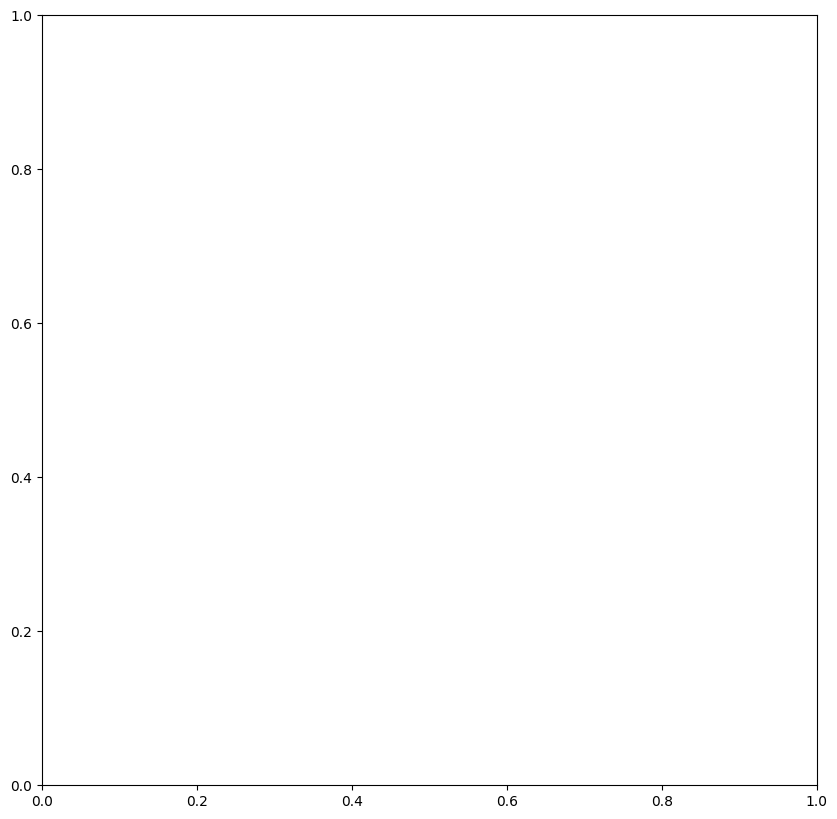

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))

# init node cooridnates
pos=nx.layout.spiral_layout(G)
#node_size = nx.get_node_attributes()
# draw node
nx.draw_networkx_nodes(G,
                       pos=pos,
                       cmap=plt.cm.RdYlBu,
                       # node_color=list(nodes.NES),
                       node_size=list(nodes.Hits_ratio *1000))
# draw node label
nx.draw_networkx_labels(G,
                        pos=pos,
                        labels=nodes.Term.to_dict())
# draw edge
edge_weight = nx.get_edge_attributes(G, 'jaccard_coef').values()
nx.draw_networkx_edges(G,
                       pos=pos,
                       width=list(map(lambda x: x*10, edge_weight)),
                       edge_color='#CDDBD4')
plt.show()


## Some thoughts
